In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE, global_mean_pool
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from collections import Counter

In [14]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [22]:
class ImbalancedGraphSAGE(torch.nn.Module):
    """
    GraphSAGE model optimized for imbalanced classification
    """
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout=0.2):  # Larger model
        super().__init__()
        
        self.sage = GraphSAGE(
            in_channels=input_dim,
            hidden_channels=hidden_dim,  # Increase from 128 to 256
            num_layers=4,                # Increase from 3 to 4
            out_channels=hidden_dim,
            dropout=dropout,
            act='relu'
        )
        
        # Deeper classification head
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            
            torch.nn.Linear(hidden_dim, hidden_dim // 2),
            torch.nn.BatchNorm1d(hidden_dim // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            
            torch.nn.Linear(hidden_dim // 2, hidden_dim // 4),
            torch.nn.BatchNorm1d(hidden_dim // 4),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            
            torch.nn.Linear(hidden_dim // 4, num_classes)
        )
        
    def forward(self, x, edge_index, batch):
        # Node embeddings via GraphSAGE
        node_embeddings = self.sage(x, edge_index)
        
        # Graph-level embedding via global mean pooling
        graph_embedding = global_mean_pool(node_embeddings, batch)
        
        # Classification logits
        logits = self.classifier(graph_embedding)
        
        return logits

class WeightedFocalLoss(torch.nn.Module):
    """
    Focal Loss with class weights for handling extreme imbalance
    """
    def __init__(self, class_weights, alpha=1.0, gamma=2.0):
        super(WeightedFocalLoss, self).__init__()
        self.class_weights = class_weights
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.class_weights, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

def calculate_class_weights(y_train, num_classes):
    """
    Calculate class weights for imbalanced data
    """
    class_counts = Counter(y_train.numpy())
    total_samples = len(y_train)
    
    class_weights = []
    for i in range(num_classes):
        count = class_counts.get(i, 1)
        # More extreme weighting
        weight = (total_samples / count) ** 0.75  # Power scaling
        class_weights.append(weight)
    
    return torch.tensor(class_weights, dtype=torch.float)

def create_balanced_dataloader(data_list, batch_size, is_train=True):
    """
    Create dataloader with class-aware sampling for training
    """
    if is_train:
        # Calculate sampling weights for balanced training
        class_counts = Counter([data.y.item() for data in data_list])
        total_samples = len(data_list)
        
        # Create sampling weights (inverse of class frequency)
        sample_weights = []
        for data in data_list:
            class_label = data.y.item()
            weight = total_samples / (len(class_counts) * class_counts[class_label])
            sample_weights.append(weight)
        
        # Create weighted sampler
        sampler = torch.utils.data.WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(data_list),
            replacement=True
        )
        
        return DataLoader(data_list, batch_size=batch_size, sampler=sampler)
    else:
        return DataLoader(data_list, batch_size=batch_size, shuffle=False)

def train_epoch(model, loader, optimizer, criterion, device):
    """
    Training epoch with gradient clipping
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(loader, desc="Training"):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(logits, batch.y)
        
        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += batch.y.size(0)
    
    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device, num_classes):
    """
    Evaluation with detailed metrics
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(logits, batch.y)
            
            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(batch.y.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    f1_macro = f1_score(all_targets, all_preds, average='macro')
    f1_weighted = f1_score(all_targets, all_preds, average='weighted')
    
    return (total_loss / len(loader), accuracy, f1_macro, f1_weighted, 
            all_preds, all_targets)

def plot_training_results(train_losses, val_losses, train_accs, val_accs, 
                         val_f1_macros, val_f1_weighteds):
    """
    Plot training progress
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    axes[0, 0].plot(train_losses, label='Train Loss', alpha=0.8)
    axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.8)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[0, 1].plot(train_accs, label='Train Accuracy', alpha=0.8)
    axes[0, 1].plot(val_accs, label='Validation Accuracy', alpha=0.8)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 scores
    axes[1, 0].plot(val_f1_macros, label='F1 Macro', alpha=0.8)
    axes[1, 0].plot(val_f1_weighteds, label='F1 Weighted', alpha=0.8)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title('Validation F1 Scores')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Confusion matrix (placeholder)
    axes[1, 1].text(0.5, 0.5, 'Confusion Matrix\n(See separate plot)', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Final Results')
    
    plt.tight_layout()
    plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


In [23]:
print("Loading preprocessed data...")
    
# Load data
with open('processed_circuit_data_classification.pkl', 'rb') as f:
    all_data = pickle.load(f)
    
print(f"Loaded {len(all_data)} data samples")

Loading preprocessed data...
Loaded 602 data samples


In [24]:
# Analyze class distribution
class_counts = Counter([data.y.item() for data in all_data])
print("Class distribution:")
for class_id, count in sorted(class_counts.items()):
    percentage = count / len(all_data) * 100
    print(f"  Class {class_id}: {count} samples ({percentage:.1f}%)")
    
# Data splitting - stratify by circuit to avoid data leakage
circuit_names = [data.circuit_name for data in all_data]
    
# Split by circuit to avoid leakage
unique_circuits = list(set(circuit_names))
train_circuits, temp_circuits = train_test_split(
        unique_circuits, test_size=0.3, random_state=42
    )
val_circuits, test_circuits = train_test_split(
        temp_circuits, test_size=0.5, random_state=42
    )

Class distribution:
  Class 0: 46 samples (7.6%)
  Class 1: 30 samples (5.0%)
  Class 2: 526 samples (87.4%)


In [25]:
# Create data splits
train_data = [data for data in all_data if data.circuit_name in train_circuits]
val_data = [data for data in all_data if data.circuit_name in val_circuits]
test_data = [data for data in all_data if data.circuit_name in test_circuits]
    
print(f"\nData splits:")
print(f"Train: {len(train_data)} samples from {len(train_circuits)} circuits")
print(f"Val: {len(val_data)} samples from {len(val_circuits)} circuits")
print(f"Test: {len(test_data)} samples from {len(test_circuits)} circuits")
    
# Create data loaders
batch_size = 16  # Smaller batch size for imbalanced data
train_loader = create_balanced_dataloader(train_data, batch_size, is_train=True)
val_loader = create_balanced_dataloader(val_data, batch_size, is_train=False)
test_loader = create_balanced_dataloader(test_data, batch_size, is_train=False)


Data splits:
Train: 259 samples from 7 circuits
Val: 35 samples from 1 circuits
Test: 308 samples from 2 circuits


c:\Users\sidharth\AppData\Local\anaconda3\envs\agent\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [26]:
# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
    
input_dim = all_data[0].x.shape[1]
num_classes = len(class_counts)
    
model = ImbalancedGraphSAGE(
        input_dim=input_dim,
        hidden_dim=128,
        num_classes=num_classes,
        dropout=0.3
    ).to(device)
    
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
Model parameters: 129,539


In [27]:
# Calculate class weights
train_targets = torch.tensor([data.y.item() for data in train_data])
class_weights = calculate_class_weights(train_targets, num_classes).to(device)
print(f"Class weights: {class_weights}")
    
# Loss function and optimizer
criterion = WeightedFocalLoss(class_weights, alpha=2.0, gamma=3.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# Training loop
num_epochs = 100
best_val_f1 = 0
patience = 25
patience_counter = 0
    
# Tracking metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_f1_macros, val_f1_weighteds = [], []

Class weights: tensor([10.0136,  8.4704,  1.0861])


In [28]:
print("Starting training...")

for epoch in range(num_epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
    # Validation
    val_loss, val_acc, val_f1_macro, val_f1_weighted, _, _ = evaluate(
            model, val_loader, criterion, device, num_classes
        )
        
    # Learning rate scheduling based on F1 score
    scheduler.step(val_f1_weighted)
        
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_f1_macros.append(val_f1_macro)
    val_f1_weighteds.append(val_f1_weighted)
        
    # Early stopping based on F1 score
    if val_f1_weighted > best_val_f1:
        best_val_f1 = val_f1_weighted
        patience_counter = 0
        torch.save(model.state_dict(), 'best_imbalanced_model.pth')
    else:
        patience_counter += 1
        
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"          | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"          | Val F1 Macro: {val_f1_macro:.4f} | Val F1 Weighted: {val_f1_weighted:.4f}")
        print(f"          | Best F1: {best_val_f1:.4f}")
        
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
print("Training completed!")

Starting training...


Training: 100%|██████████| 17/17 [00:01<00:00,  9.83it/s]


Epoch  10 | Train Loss: 11.3131 | Train Acc: 0.5483
          | Val Loss: 10.2387 | Val Acc: 0.4000
          | Val F1 Macro: 0.2288 | Val F1 Weighted: 0.2588
          | Best F1: 0.3359


Training: 100%|██████████| 17/17 [00:01<00:00,  9.11it/s]


Epoch  20 | Train Loss: 9.4598 | Train Acc: 0.5598
          | Val Loss: 9.1704 | Val Acc: 0.4000
          | Val F1 Macro: 0.2288 | Val F1 Weighted: 0.2588
          | Best F1: 0.3359


Training: 100%|██████████| 17/17 [00:01<00:00, 11.87it/s]


Early stopping at epoch 29
Training completed!


In [29]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_imbalanced_model.pth'))
test_loss, test_acc, test_f1_macro, test_f1_weighted, test_preds, test_targets = evaluate(
        model, test_loader, criterion, device, num_classes
)


FINAL TEST RESULTS
Test Accuracy: 0.8734
Test F1 Macro: 0.6444
Test F1 Weighted: 0.8957

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.37      1.00      0.54        21
     Class 1       0.50      0.43      0.46         7
     Class 2       1.00      0.88      0.93       280

    accuracy                           0.87       308
   macro avg       0.62      0.77      0.64       308
weighted avg       0.95      0.87      0.90       308



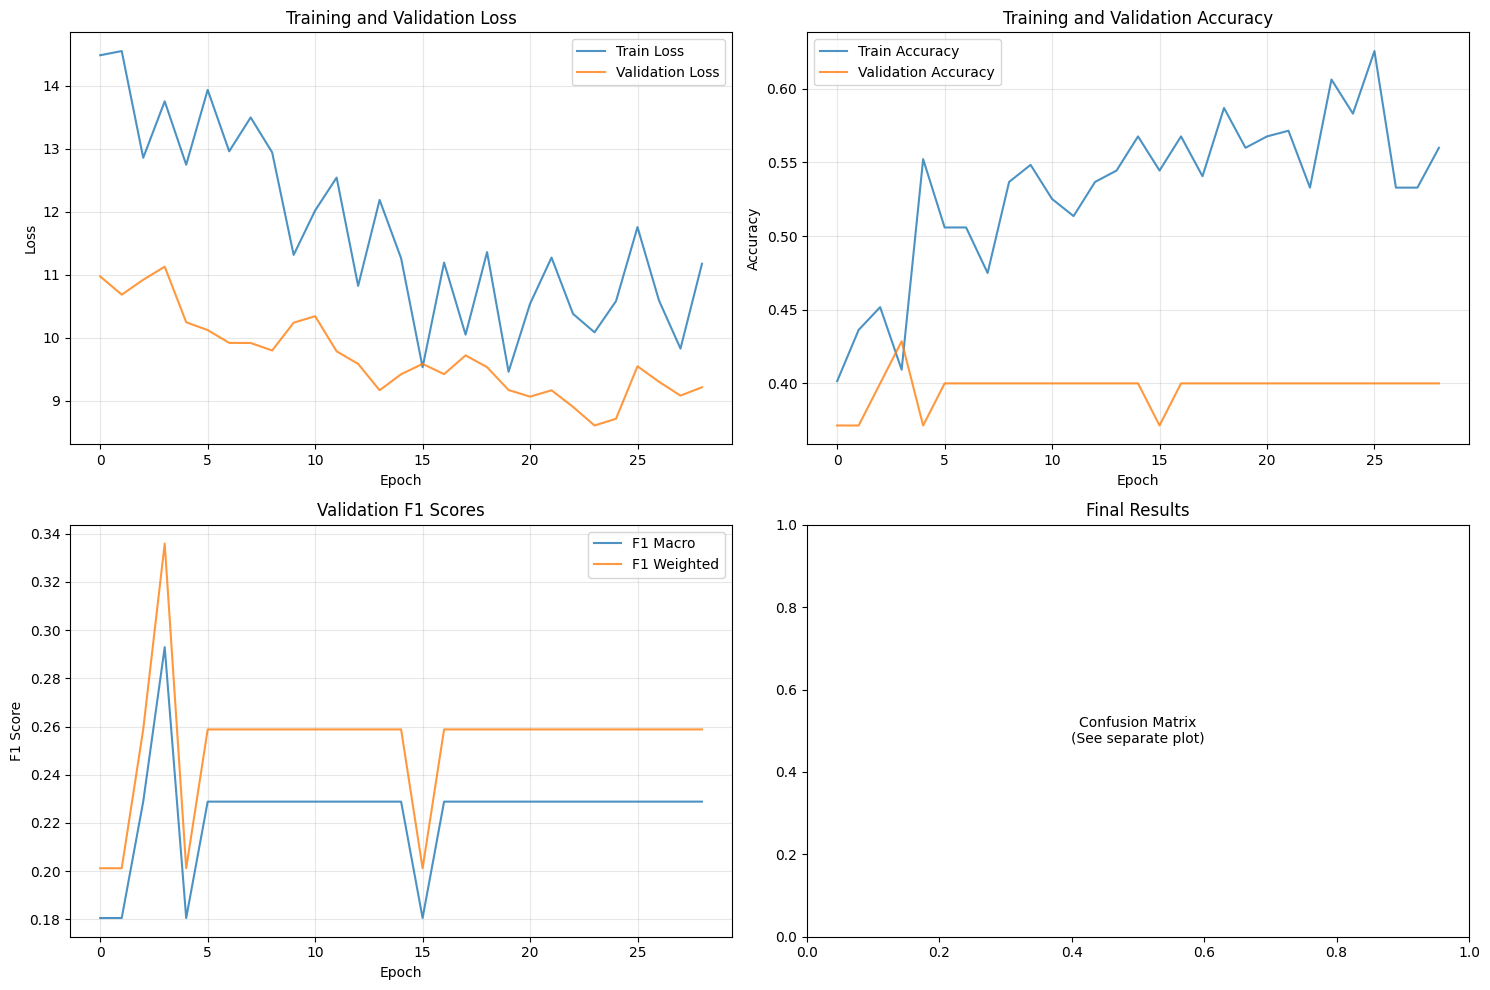

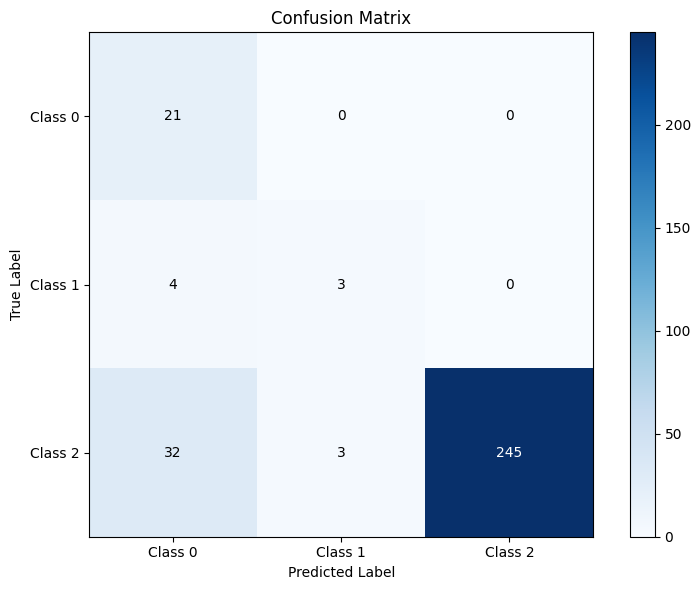


Results saved to 'imbalanced_classification_results.pkl'
Classification training complete!


In [30]:
print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Macro: {test_f1_macro:.4f}")
print(f"Test F1 Weighted: {test_f1_weighted:.4f}")
    
# Detailed classification report
class_names = [f'Class {i}' for i in range(num_classes)]
print("\nClassification Report:")
print(classification_report(test_targets, test_preds, target_names=class_names))
    
# Plot results
plot_training_results(train_losses, val_losses, train_accs, val_accs, 
                         val_f1_macros, val_f1_weighteds)
plot_confusion_matrix(test_targets, test_preds, class_names)
    
# Save final results
results = {
        'test_accuracy': test_acc,
        'test_f1_macro': test_f1_macro,
        'test_f1_weighted': test_f1_weighted,
        'class_distribution': dict(class_counts),
        'class_weights': class_weights.cpu().numpy(),
        'training_history': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'val_f1_macros': val_f1_macros,
            'val_f1_weighteds': val_f1_weighteds
        }
    }
    
with open('imbalanced_classification_results.pkl', 'wb') as f:
    pickle.dump(results, f)
    
print(f"\nResults saved to 'imbalanced_classification_results.pkl'")
print("Classification training complete!")